# Reproducing the models of Spitoni et al. (2024)

In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import vice
import paths
from track_and_mdf import setup_figure, plot_vice_onezone

In [2]:
output_dir = paths.data / 'onezone' / 'Spitoni2024'
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
plt.style.use(paths.styles / 'paper.mplstyle')
plt.rcParams['figure.dpi'] = 200

## Model Parameters

Simulation time

In [4]:
dt = 0.01
tmax = 12.5
simtime = np.arange(0, tmax+dt, dt)

Yields: the tables of Francois et al. (2004) don't change the values for Fe or O from their original sources, Woosley & Weaver (1995) and Iwamoto et al. (1999, model W7).

In [5]:
## CCSNe yields from Woosley & Weaver (1995)
from vice.yields.ccsne import WW95
# 
from vice.yields.sneia import iwamoto99
iwamoto99.set_params(model='W7')

/home/lodubay/anaconda3/envs/2inf/lib/python3.12/site-packages/vice/yields/ccsne/WW95/__init__.py:119: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  __settings[i] = __fractional(i, study = "WW95", **kwargs)[0]
/home/lodubay/anaconda3/envs/2inf/lib/python3.12/site-packages/vice/yields/ccsne/WW95/__init__.py:119: ScienceWarning: The Woosley & Weaver (1995) ApJ, 101, 181 study did not report yields for the element ga. If adopting these yields for simulation, it is likely that this yield can be approximated as zero at this metallicity. Users may exercise their own discretion by modifying their CCSN yield settings directly.
  __settings[i] = __fractional(i, study = "WW95", **kwargs)[0]
/home/lodubay/anaconda3/envs/2inf/lib/python3.12/site-packages/vice/yields/ccsne/WW95/__init__.py:119: ScienceWarning: The Woosley & Weaver (1995) ApJ, 101, 181 study did not report yields for the el

SN Ia DTD: I think they use a SD model similar to Greggio (2005)

In [6]:
from multizone.src.dtds import greggio05_single
SD_RIa = greggio05_single()

The Two-Infall Model

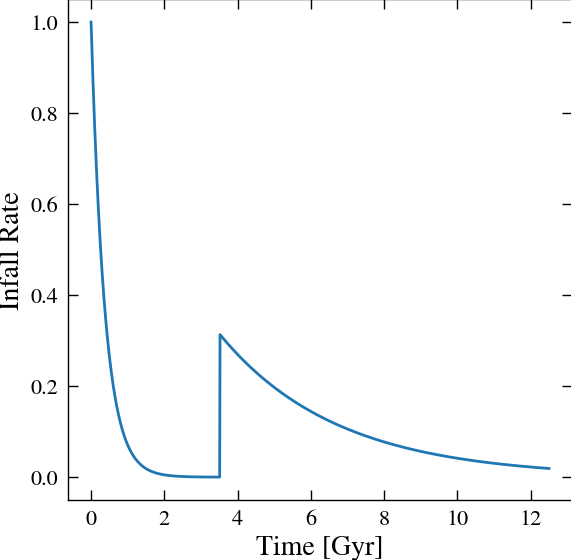

In [7]:
class OneInfall:
    def __init__(self, timescale=1, amplitude=1):
        self.timescale = timescale
        self.amplitude = amplitude
        
    def __call__(self, time):
        return self.amplitude * m.exp(-time / self.timescale)

class TwoInfall(OneInfall):
    def __init__(self, timescale1=0.377, timescale2=3.203, amplitude1=1, onset=3.519, present_mass_ratio=2.5, tmax=12.5):
        self.onset = onset
        # Calculate the amplitude ratio (second infall to first)
        amp_ratio = present_mass_ratio 
        amp_ratio *= timescale1 * (1 - m.exp(-tmax/timescale1))
        amp_ratio *= 1 / (timescale2 * (1 - m.exp(-(tmax - onset)/timescale2)))
        self.infall1 = OneInfall(timescale=timescale1, amplitude=amplitude1)
        self.infall2 = OneInfall(timescale=timescale2, amplitude=amp_ratio*amplitude1)
    
    def __call__(self, time):
        if time < self.onset:
            return self.infall1(time)
        else:
            return self.infall1(time) + self.infall2(time - self.onset)

fig, ax = plt.subplots()
twoinfall_ifr = TwoInfall()
ifr_data = np.array([twoinfall_ifr(t) for t in simtime])
ax.plot(simtime, ifr_data)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('Infall Rate')
plt.show()

The massive dwarf galaxy model

In [15]:
# As in Vincenzo et al. (2019), normalize infall to accrete a total of 10^10 Msun
dwarf_ifr = OneInfall(timescale=0.24, amplitude=(1e10/1e9)/0.24) # convert to Msun/yr
dwarf_simtime = np.arange(0, 3.81, 0.01)

dwarf = vice.singlezone(
    name=str(output_dir / 'dwarf'),
    func=dwarf_ifr,
    mode='ifr',
    elements=('fe', 'o', 'mg', 'si'),
    eta=1.5,
    delay=0.04,
    RIa=SD_RIa,
    Mg0=0,
    tau_star=1/0.42,
    dt=dt,
    # schmidt=True,
    # schmidt_index=0.5,
    # MgSchmidt=1,
    bins=[i*0.01 - 3 for i in range(401)],
)
dwarf.run(dwarf_simtime, overwrite=True)

In [16]:
dwarf_hist = vice.history(str(output_dir / 'dwarf'))
dwarf_hist

vice.dataframe{
    time -----------> [0, 0.01, 0.02, ... , 3.79, 3.8, 3.81]
    mgas -----------> [1e-12, 4.16667e+08, 8.12122e+08, ... , 5.07044e+08, 5.03226e+08, 4.9944e+08]
    mstar ----------> [0, 3.79776e-15, 1.5824e+06, ... , 2.84634e+09, 2.84696e+09, 2.84758e+09]
    sfr ------------> [4.2e-22, 0.175, 0.341091, ... , 0.212958, 0.211355, 0.209765]
    ifr ------------> [41.6667, 39.9662, 38.3352, ... , 5.77504e-06, 5.53936e-06, 5.31329e-06]
    ofr ------------> [3.75891e+119, 0.2625, 0.511637, ... , 0.319438, 0.317032, 0.314647]
    eta_0 ----------> [1.5, 1.5, 1.5, ... , 1.5, 1.5, 1.5]
    r_eff ----------> [0.0957713, 0.0957713, 0.120737, ... , 0.707069, 0.708799, 0.710535]
    z_in(fe) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(o) --------> [0, 0, 0, ... , 0, 0, 0]
    z_in(mg) -------> [0, 0, 0, ... , 0, 0, 0]
    z_in(si) -------> [0, 0, 0, ... , 0, 0, 0]
    z_out(fe) ------> [0, 4.3651e-06, 4.36685e-06, ... , 0.00437222, 0.00438979, 0.00440736]
    z_out(o) -------> [-0

In [17]:
# Disk evolution start time
tdisk = 1.3
dwarf_hist['[fe/h]'][int(tdisk*100)]

-0.24674780009381433

(-3.0, 0.5)

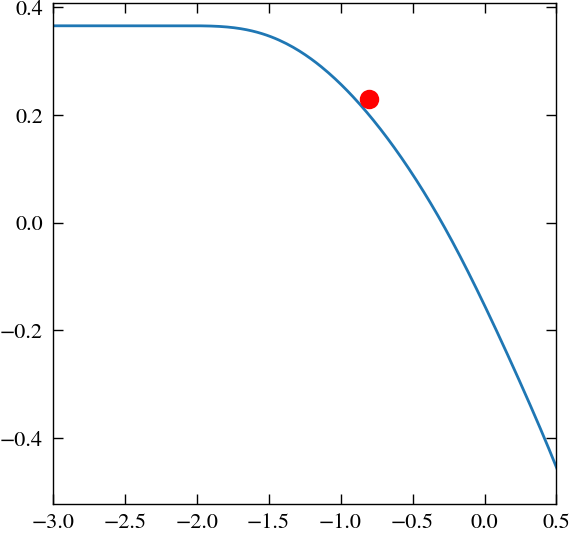

In [18]:
plt.plot(dwarf_hist['[fe/h]'], np.array(dwarf_hist['[mg/fe]']) + np.array(dwarf_hist['[si/fe]']))
plt.plot(-0.8, 0.23, 'ro')
plt.xlim((-3, 0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


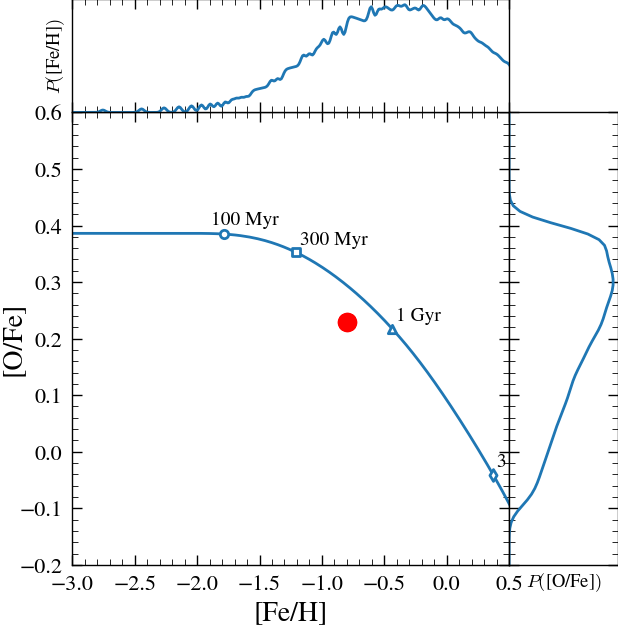

In [19]:
fig, axs = setup_figure(xlim=(-3, 0.5), ylim=(-0.2, 0.6))

plot_vice_onezone(str(output_dir / 'dwarf'), 
                  fig=fig, axs=axs,
                  label='',
                  marker_labels=True)
axs[0].plot(-0.8, 0.23, 'ro')
axs[0].plot(-0.8, 0.23, 'ro')

axs[1].set_ylim(bottom=0)
axs[2].set_xlim(left=0)
axs[0].legend(frameon=False, loc='lower left')
plt.show()

In [20]:
dwarf_mdf = vice.mdf(str(output_dir / 'dwarf'))
dwarf_mdf

vice.dataframe{
    bin_edge_left --> [-3, -2.99, -2.98, ... , 0.97, 0.98, 0.99]
    bin_edge_right -> [-2.99, -2.98, -2.97, ... , 0.98, 0.99, 1]
    dn/d[fe/h] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[o/h] ------> [0, 0, 0, ... , 0, 0, 0]
    dn/d[mg/h] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[si/h] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[o/fe] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[mg/fe] ----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[mg/o] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[si/fe] ----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[si/o] -----> [0, 0, 0, ... , 0, 0, 0]
    dn/d[si/mg] ----> [0, 0, 0, ... , 0, 0, 0]
}

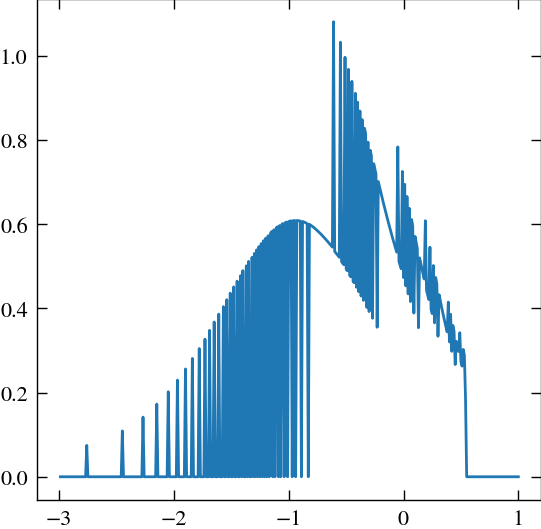

In [21]:
plt.plot(dwarf_mdf['bin_edge_right'], dwarf_mdf['dn/d[fe/h]'])
plt.show()